# Geometric Accuracy of Sentinel-1 NRB sample product and comparison to GAMMA output

This notebooks compares geometric accuracy assessment for data prodcued by Sinergise and by GAMMA.

One GRD scene from 2019 Oct 11 is used.


### Prepare input data

In [1]:
!ls ../../S1_samples/CR_gamma/HH-Gamma0_rtc-pwr_S1-IW_Cop30_20191011_SuratBasin

HH-Gamma0_rtc-pwr_S1-IW_Cop30_20191011_SuratBasin_Float32_Bspline3_2x1look.tif
HH-Gamma0_rtc-pwr_S1-IW_Cop30_20191011_SuratBasin_Float32_NN-1x1look.tif
HH-Gamma0_rtc-pwr_S1-IW_Cop30_20191011_SuratBasin_Float32_NN-2x2look.tif


### Load S1 sample data

HH band is available in ascending pass.

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import os, glob
from matplotlib import pyplot as plt

In [3]:
#!pip install photutils --user
from photutils.centroids import centroid_2dg
from scipy import interpolate
from scipy import ndimage

In [4]:
# sinergise sample
fnames = glob.glob('../../S1_samples/CR_sinergise_shifted/*_NEAREST/HH.tif')
data = [xr.open_rasterio(fname, chunks={'x':1000, 'y':1000}).squeeze().to_dataset(name='HH') for fname in fnames]

fnames = glob.glob('../../S1_samples/CR_sinergise_shifted/*_NEAREST/MASK.tif')            
data += [xr.open_rasterio(fname, chunks={'x':1000, 'y':1000}).squeeze().to_dataset(name='MASK') for fname in fnames]

combined = xr.combine_by_coords(data)

In [5]:
# gamma output
fname = '../../S1_samples/CR_gamma/HH-Gamma0_rtc-pwr_S1-IW_Cop30_20191011_SuratBasin/HH-Gamma0_rtc-pwr_S1-IW_Cop30_20191011_SuratBasin_Float32_NN-2x2look.tif'
gamma = xr.open_rasterio(fname, chunks={'x':1000, 'y':1000}).squeeze().to_dataset(name='HH')


In [6]:
x_slice = slice(np.max([combined.x.values[0], gamma.x.values[0]]), np.min([combined.x.values[-1], gamma.x.values[-1]]))
y_slice = slice(np.max([combined.y.values[0], gamma.y.values[0]]), np.min([combined.x.values[-1], gamma.y.values[-1]]))


In [7]:
combined = combined.sel(x=x_slice, y = y_slice)
gamma = gamma.sel(x=x_slice, y = y_slice)

### Load corner reflector locations

In [8]:
import pandas as pd

In [9]:
cr_locations = pd.read_csv('../../S1_samples/QLD_corner_reflector_positions_GDA2020.txt', sep="\s+", header=0)

In [10]:
cr_locations.head()

,Name,Latitude,Longitude,Height,X,Y,Z,veloX,veloY,veloZ,Azimuth,Elevation
0,SB01-CRApex,-26.834710,151.165604,409.4544,-4.989394e+06,2.746844e+06,-2.862070e+06,-0.0325,-0.0083,0.0487,257.10,53.32
1,SB02-CRApex,-26.951633,151.237613,432.7094,-4.987723e+06,2.737762e+06,-2.873636e+06,-0.0325,-0.0082,0.0486,256.21,53.33
2,SB03-CRApex,-27.100732,151.258809,391.8599,-4.982121e+06,2.732289e+06,-2.888335e+06,-0.0326,-0.0081,0.0485,258.46,54.34
3,SB04-CRApex,-27.308871,151.271959,385.2420,-4.973496e+06,2.726074e+06,-2.908845e+06,-0.0326,-0.0079,0.0484,258.51,54.67
4,SB05-CRApex,-27.456930,151.190830,403.0057,-4.963033e+06,2.729485e+06,-2.923422e+06,-0.0327,-0.0077,0.0484,258.20,55.36


In [11]:
col_lat = [n for n in list(cr_locations.columns) if 'Latitude' in n]
col_lon = [n for n in list(cr_locations.columns) if 'Longitude' in n]

In [12]:
cr_locations= cr_locations[cr_locations[col_lat].notnull().values & cr_locations[col_lon].notnull().values]

In [13]:
len(cr_locations)

40

### Find peak backscatter in each stamp around a CR

Three methods are used:
1. center of mass measured from entire stamp
2. cetroild measured from a 2d gaussian fit

In [14]:
ps = 0.0002 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon_1 = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
mpd_lon_2 =111.32*1000*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) #for minimum meter per degree lon
mpd_lon = (mpd_lon_1+mpd_lon_2)/2

#### Center of mass using all pixels

In [15]:
hs = 0.0008

s1 = combined.HH.compute()

data_crs = []
true_lats = []
true_lons = []

for idx, row in cr_locations.iterrows():
    try:
        # is the CR in the scene?
        d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
        x0, y0 = d.x.values, d.y.values
        #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        # is it visible?
        peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
        try:
            if peak.max()>2: 
                #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                data_crs.append(data)
                true_lats.append(row[col_lat].values[0])
                true_lons.append(row[col_lon].values[0])
            else:
                print("not visible?", peak.max().values)
        except: 
            #print(i, data, peak)
            pass
    except KeyError:
        pass
    # 

print(len(data_crs))
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)
# gaussian centroid 

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # gaussian centroid
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = centroid_2dg(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

    
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

39
RMSE Latitude (pixel) 0.5163551488995152
RMSE Longitude (pixel) 0.38561551828425067
RMSE Latitude (meter) 11.496131035098806
RMSE Longitude (meter) 7.646715299341687


RMSE Latitude (pixel) 0.18860388419739682
RMSE Longitude (pixel) 0.347719882830565
RMSE Latitude (meter) 4.199076877770843
RMSE Longitude (meter) 6.895248821303403


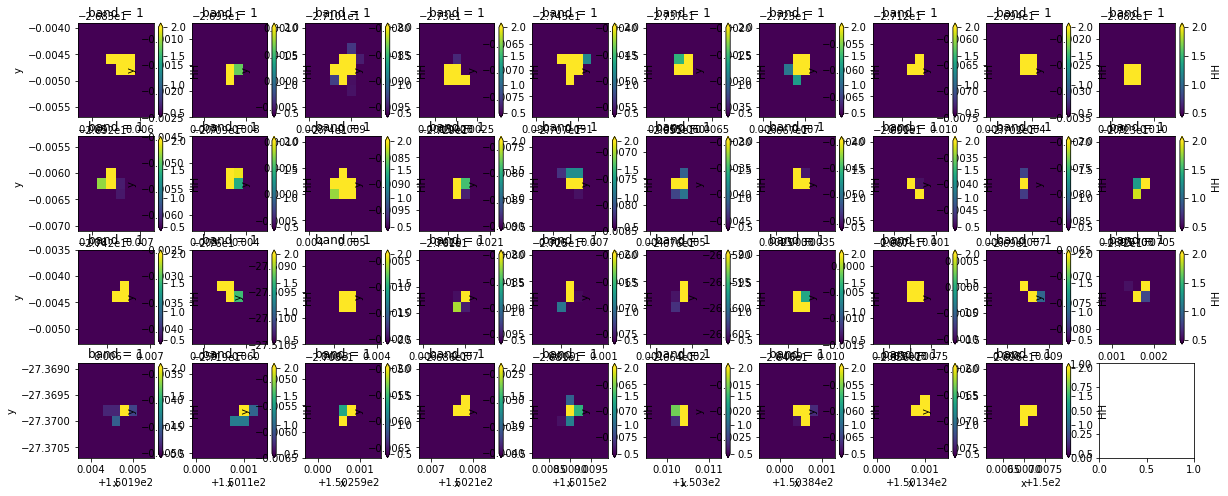

In [16]:
# visual check selected stamps

f, ax = plt.subplots(4,10,figsize=(20,8))
ax = ax.flatten()
for i in range(len(data_crs)):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.5, vmax=2);

## GAMMA output

In [17]:
hs = 0.0008

s1 = gamma.HH.compute()

data_crs = []
true_lats = []
true_lons = []

for idx, row in cr_locations.iterrows():
    try:
        # is the CR in the scene?
        d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
        x0, y0 = d.x.values, d.y.values
        #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        # is it visible?
        peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
        try:
            if peak.max()>2: 
                #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                data_crs.append(data)
                true_lats.append(row[col_lat].values[0])
                true_lons.append(row[col_lon].values[0])
            else:
                print("not visible?", peak.max().values)
        except: 
            #print(i, data, peak)
            pass
    except KeyError:
        pass
    # 
  
print(len(data_crs))
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

# gaussian centroid 

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # gaussian centroid
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = centroid_2dg(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

    
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

not visible? 0.0
38
RMSE Latitude (pixel) 0.6987551222659906
RMSE Longitude (pixel) 0.45621928979907683
RMSE Latitude (meter) 15.557084042130015
RMSE Longitude (meter) 9.046780686325611


RMSE Latitude (pixel) 0.22642577944655654
RMSE Longitude (pixel) 0.5444033948580177
RMSE Latitude (meter) 5.041143553598135
RMSE Longitude (meter) 10.795462244353299


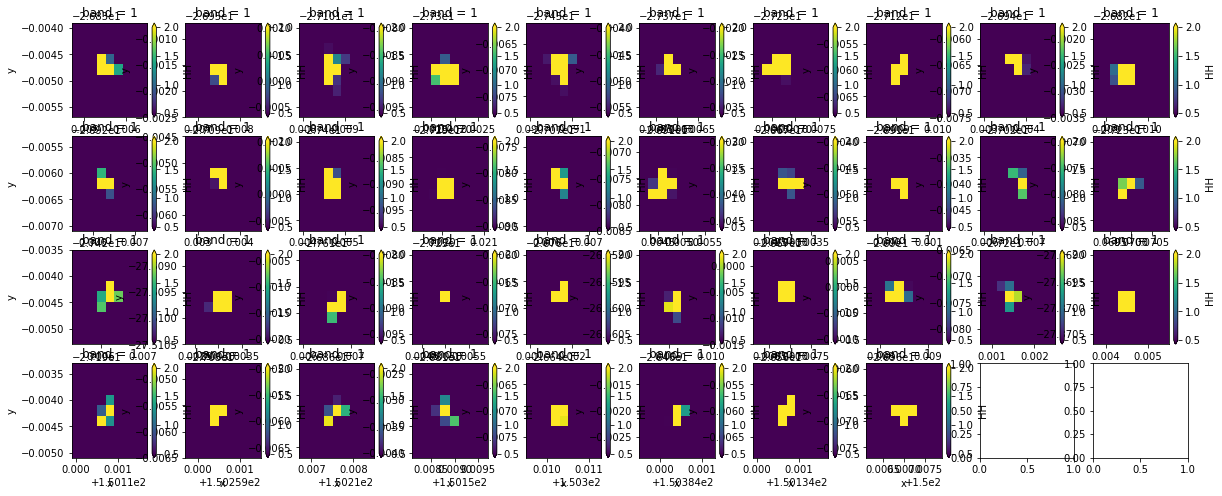

In [18]:
# visual check selected stamps

f, ax = plt.subplots(4,10,figsize=(20,8))
ax = ax.flatten()
for i in range(len(data_crs)):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.5, vmax=2);